In [266]:
# import package
import numpy as np
import pandas as pd

# plot package
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [267]:
# import dataset 
song = pd.read_csv('data.csv')
genre1 = pd.read_csv('data_by_genres.csv')
genre2 = pd.read_csv('data_w_genres.csv')
genre = pd.read_csv('SpotifyFeatures.csv')

## Web scrape hot 100 songs for each year using billboard API

In [268]:
# Webscrape hot 100 songs using billboard API and then export as excel 
#!pip install billboard.py
#import billboard
#for i in range(1970,2020):
#    chart = billboard.ChartData('hot-100-songs', year=i)
#hitsong2020 = billboard.ChartData('hot-100')

In [269]:
# import data for Billboard hot 100 since 1970 and clean the columns of trackname and artists in order to get a better 
# match when we join our main dataset with billboard data 
billboard = pd.read_excel('Billboard Hit Songs.xlsx')
billboard = billboard.trackname.str.split('.',1,expand=True)
hitsong = billboard.iloc[:,1].str.split('by',1,expand=True)
hitsong['rank'] = billboard.iloc[:,0]
hitsong['trackname'] = hitsong.iloc[:,0].apply(lambda x: x.replace('\'','').replace('(','').replace(')','').replace('?','').
                                       replace('/','').replace(',','').replace('.','').replace('?','').replace('&','').
                                       replace('-','').replace(':','').lower().strip())
hitsong['artist'] = hitsong.iloc[:,1].apply(lambda x: x.replace('\"','').replace('\'','').replace('”','').replace('[','').
                                      replace('.','').replace(',','').replace(']','').replace('?','').replace('(','').
                                      replace(')','').lower().strip())
song['artists'] = song.artists.apply(lambda x: x.replace('\"','').replace('\'','').replace('”','').replace('[','').
                                 replace('.','').replace(',','').replace(']','').replace('?','').replace('(','').
                                     replace(')','').lower().strip())
song['name'] = song.name.apply(lambda x: x.replace('\'','').replace('(','').replace(')','').replace('?','').
                                       replace('/','').replace(',','').replace('.','').replace('?','').replace('&','').
                                       replace('-','').replace(':','').lower().strip())
hitsong = hitsong[['rank','trackname','artist']]

In [270]:
# add year into the billboard hitsong dataset (redundant )
hitsong['year'] = 1970
year = 1970
for i in range(1, len(hitsong)):
    if hitsong.iloc[i,0] == '1':
        year +=1
    hitsong.iloc[i,3] = year      

In [271]:
# Ignore warning
import warnings 
warnings.filterwarnings("ignore")
# Join the billboard hitsongs data with main data
song = song[song.year >= 1970]
topsong = hitsong.trackname
song['hitsong'] = 0
song.hitsong[song.name.isin(topsong)] = 1

## Join 2020 songs data with genre2

In [272]:
# clean the columns of artists column and genre 
genre2['artists'] = genre2.artists.apply(lambda x: x.replace('\"','').replace('\'','').replace('”','').replace('[','').
                                 replace('.','').replace(',','').replace(']','').replace('?','').replace('(','').
                                     replace(')','').lower().strip())
genre['genre'] = genre.genre.apply(lambda x: x.replace('\'','').replace('’','').lower().strip())
genre2['genres'] = genre2.genres.apply(lambda x: x.replace('\'','').replace('’','').lower().strip())
genrelist = list(genre.genre.drop_duplicates())[:-1]

In [273]:
# concatenate genre with 2020 dataset by column of artists
song2020 = song[song.year==2020]
genre2 = genre2[['artists','genres']]
song2020 = pd.merge(song2020, genre2, how='left', on = 'artists')
song2020 = song2020[song2020.genres.notna()]
artists2020 = song2020.artists
genre2020 = song2020.genres.apply(lambda x: x.replace('\'','').replace('’','').replace('[','')
                                  .replace(']','').strip())
genre2020 = pd.concat([artists2020,genre2020], axis=1)

In [274]:
# Create dummy variable for genres for 2020 songs
spl = genre2020['genres'].str.split(',', expand = True)
df2020 = pd.DataFrame()
for i in list(genrelist):
    x = pd.DataFrame(spl.iloc[:,0].str.contains(i).astype(int))
    df2020 = pd.concat([df2020,x], axis = 1)
df2020.columns = genrelist

In [275]:
# reorder the genre name in order to get the same order with our main dataset 
df2020 = df2020.drop(['a capella','comedy'],axis=1)
df2020 = df2020[['alternative','anime','blues','childrens music','classical','country','dance','electronic','folk'
       ,'hip-hop','indie','jazz','movie','opera','pop','r&b','rap','reggae','reggaeton','rock'
       ,'ska','soul','soundtrack','world']]
song2020['duration_min'] = song2020['duration_ms']/60000

In [276]:
song2020 = pd.concat([song2020, df2020], axis = 1).reset_index().drop(['index','genres','artists','id'],
                                                                    axis = 1)

In [277]:
# covert genre, key & year to dummy variables
key_dm = pd.get_dummies(song2020.key, prefix='key')
year_dm = pd.get_dummies(song2020.year, prefix='year')
year_dm['year_2014'] = 0
year_dm['year_2015'] = 0
year_dm['year_2016'] = 0
year_dm['year_2017'] = 0
year_dm['year_2018'] = 0
year_dm['year_2019'] = 0
year_dm = year_dm.reindex(columns=['year_2014','year_2015','year_2016','year_2017','year_2018',
                                   'year_2019','year_2020'])

In [278]:
# drop unpredictable data set 
name2020 = song2020.name
song2020 = song2020.drop(['key','year','duration_ms','popularity','name','release_date'], axis =1)
song2020 = pd.concat([song2020, key_dm, year_dm], axis=1)

## Data Cleaning

In [279]:
# join main dataset with genre data
genre = genre[['genre','track_name','track_id']]
df = pd.merge(genre, song, how='left', left_on = 'track_id', right_on = 'id')
df = df[df.id.notna()]

In [280]:
# drop duplicate id column
df = df.drop(['id','track_name','release_date'], axis = 1)

In [281]:
# clean the artists, name, genre columns
df['artists'] = df.artists.apply(lambda x: x.replace('\"','').replace('\'','').replace('”','').replace('[','').
                                      replace('.','').replace(',','').replace(']','').replace('?','').replace('(','').
                                      replace(')','').strip())
df['genre'] = df.genre.apply(lambda x: x.replace('\'','').replace('’','').strip())

In [282]:
song2019EDA = df[(df.year >= 2014) & (df.year < 2020)]

## Pre-processing

In [283]:
df = df.drop(['name', 'artists', 'track_id'], axis = 1)

In [284]:
# change data type
df['explicit'] = df.explicit.astype(int)
df['key'] = df.key.astype(int)
df['year'] = df.year.astype(int)
df['explicit'] = df.explicit.astype(int)
df['mode'] = df['mode'].astype(int)

In [285]:
# convert the miliseconds to minutes
df['duration_min'] = df['duration_ms']/60000

In [286]:
# select song between year 2014 and 2020
song2019 = df[(df.year >= 2014) & (df.year < 2020)]
only2019 = song2019EDA[song2019EDA.year == 2019]

In [287]:
# covert genre, key & year to dummy variables
genre_dm = pd.get_dummies(song2019.genre)
key_dm = pd.get_dummies(song2019.key, prefix='key')
year_dm = pd.get_dummies(song2019.year, prefix='year')
year_dm['year_2020'] = 0

In [288]:
# concatenate the dataset with dummy variables
song2019 = song2019.drop(['genre','key','year','duration_ms'], axis =1)
song2019 = pd.concat([song2019, genre_dm, key_dm, year_dm], axis=1)

In [289]:
# reset the index 
song2019 = song2019.reset_index().drop(['index'], axis =1)

In [290]:
# check descriptive stats 
import statistics 
avg_po = (song2019.popularity.sum()/song2019.popularity.count())
max_po = song2019.popularity.max()
min_po = song2019.popularity.min()
med_po = statistics.median(song2019.popularity)

print('Average popularity for songs is: %0.4f' %avg_po)
print('Max popularity for songs is: %0.4f' %max_po)
print('Min popularity for songs is: %0.4f' %min_po)
print('Median popularity for songs is: %0.4f' %med_po)
print('Q1 quantile of popularity for songs : ', np.quantile(song2019.popularity, .25)) 
print('Q2 quantile of popularity for songs : ', np.quantile(song2019.popularity, .50)) 
print('Q3 quantile of popularity for songs : ', np.quantile(song2019.popularity, .75)) 
print('100th quantile of popularity for songs : ', np.quantile(song2019.popularity, .1)) 

Average popularity for songs is: 62.5997
Max popularity for songs is: 92.0000
Min popularity for songs is: 45.0000
Median popularity for songs is: 62.0000
Q1 quantile of popularity for songs :  57.0
Q2 quantile of popularity for songs :  62.0
Q3 quantile of popularity for songs :  67.0
100th quantile of popularity for songs :  53.0


In [291]:
# set high rate if popularity is greater than 62
song2019['highRate'] = np.where(song2019.popularity > 62, 1, 0)
song2019EDA['highRate'] = np.where(song2019EDA.popularity > 62, 1, 0)
only2019['highRate'] = np.where(only2019.popularity > 62, 1, 0)
song['highRate'] = np.where(song.popularity > 62, 1, 0)

In [292]:
# check high rate distribution
pos = song2019[(song2019.highRate) == 1]
pos_p = len(pos) / len(song2019)
neg_p = 1 - pos_p
print('Positive instance percentage is ',pos_p)
print('Negative instance percentage is ',neg_p)

Positive instance percentage is  0.47783489567583914
Negative instance percentage is  0.5221651043241609


## EDA

In [27]:
# # Data visuluzation
# #song2019EDA # 16535 rows
# song2019EDA2 = pd.DataFrame(song2019EDA.groupby("artists")['name'])

# song2019EDA2

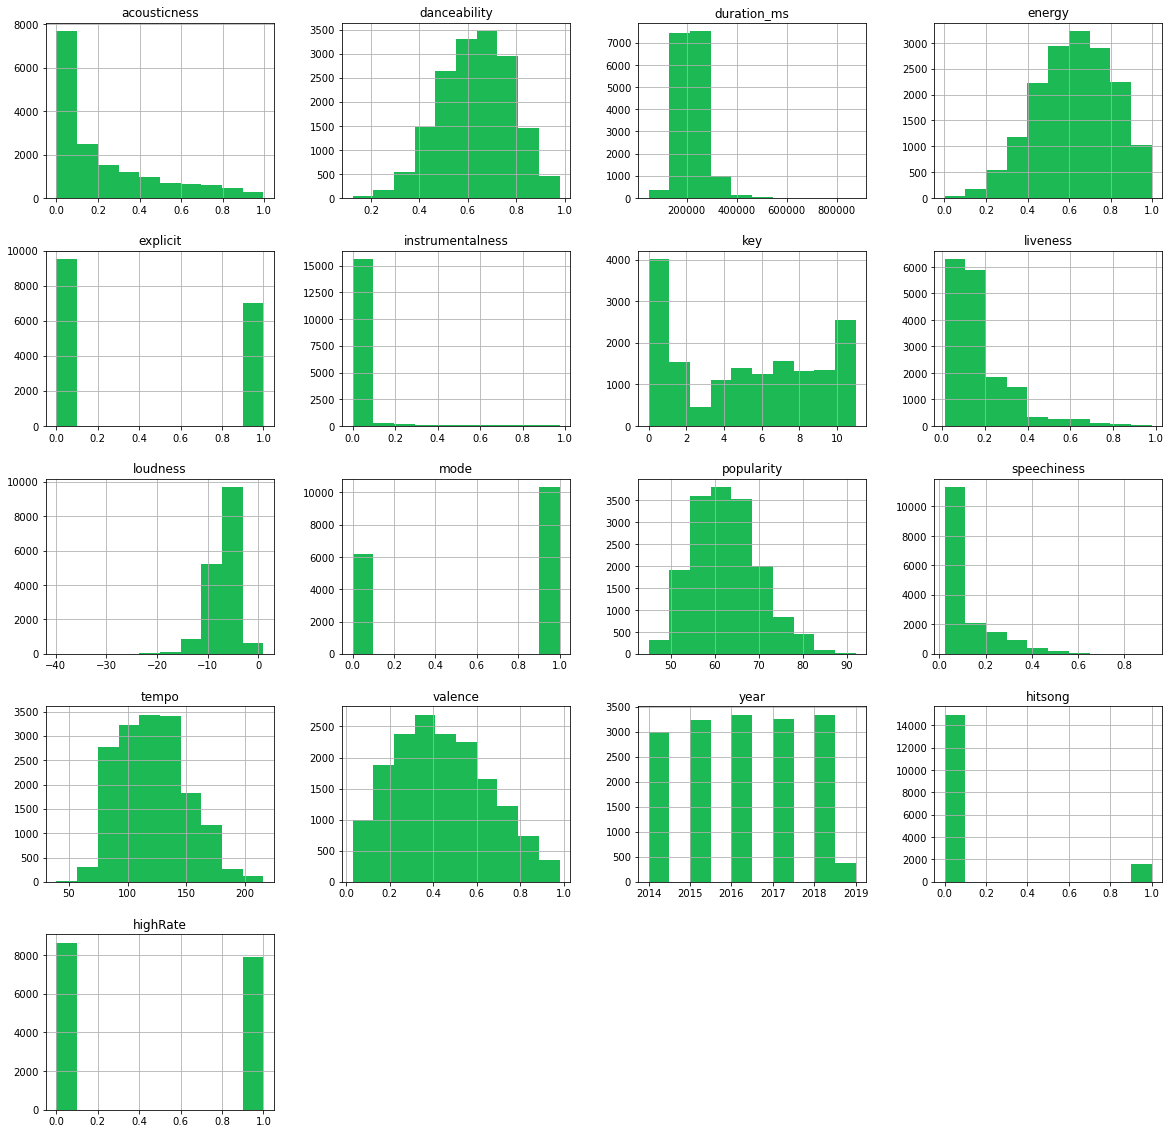

In [28]:
song2019EDA.hist(figsize=(20, 20), color = '#1DB954')
plt.show()

Text(0, 0.5, '')

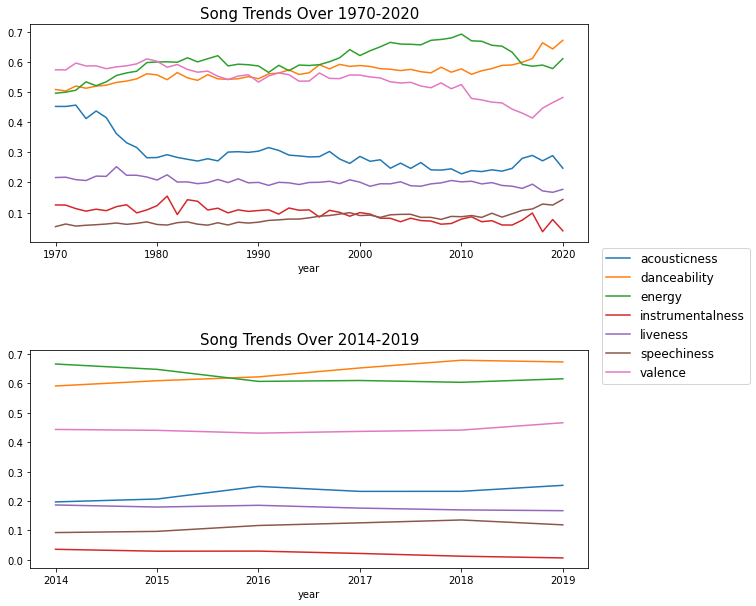

In [29]:
# https://www.kaggle.com/touchinstance/spotify/data

year_avg = song[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence',
                 'year']].groupby('year').mean().sort_values(by='year').reset_index()

plt.figure(figsize=(10,10))

#plt.figure()
plt.subplot(211)
plt.subplots_adjust(hspace=0.5)

plt.title("Song Trends Over 1970-2020", fontsize=15)
lines = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence']
for line in lines:
    ax = sns.lineplot(x='year', y=line, data=year_avg)
plt.ylabel("", fontsize=16)
plt.legend(lines,bbox_to_anchor=(1.3, 0), fontsize='large')


year_avg = song2019EDA[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence',
                 'year']].groupby('year').mean().sort_values(by='year').reset_index()
plt.subplot(212)
plt.title("Song Trends Over 2014-2019", fontsize=15)
lines = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence']
for line in lines:
    ax = sns.lineplot(x='year', y=line, data=year_avg)
plt.ylabel("", fontsize=16)

Text(0.5, 1.0, 'Song popularity overtime. 2014-2019 ')

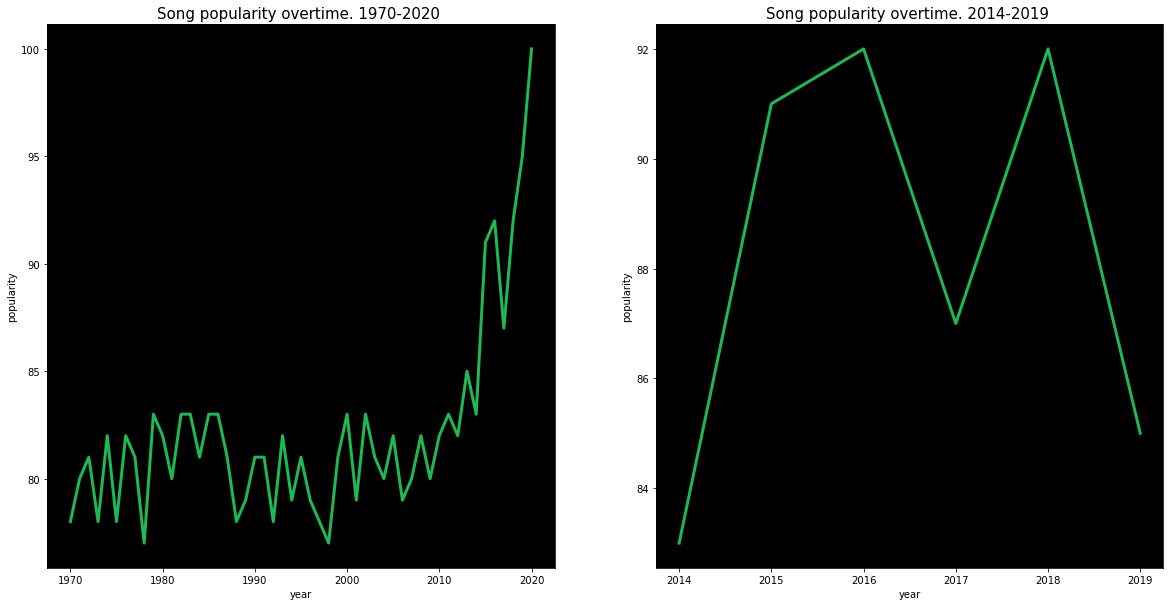

In [30]:
# Top Songs by Popularity
# looks at the most popular song from each year

pop_year = song.sort_values('popularity', ascending=False).groupby('year').first()
pop_year = pop_year.reset_index()
pop_year = pop_year[['year', 'artists', 'name', 'popularity']]

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
#pop_year
sns.lineplot(pop_year['year'], pop_year['popularity'], linewidth = 3, color = '#1DB954').set_facecolor('black')
plt.title("Song popularity overtime. 1970-2020 ", fontsize=15)



pop_year = song2019EDA.sort_values('popularity', ascending=False).groupby('year').first()
pop_year = pop_year.reset_index()
pop_year = pop_year[['year', 'artists', 'name', 'popularity']]


plt.subplot(1, 2, 2)
#pop_year
sns.lineplot(pop_year['year'], pop_year['popularity'], linewidth = 3, color = '#1DB954').set_facecolor('black')
plt.title("Song popularity overtime. 2014-2019 ", fontsize=15)

# popularity is determined by streams, older songs don't get as much streaming?


## FIX TITLES

In [31]:
pop_year

,year,artists,name,popularity
0,2014.0,ed sheeran,photograph,83.0
1,2015.0,melanie martinez,play date,91.0
2,2016.0,travis scott,goosebumps,92.0
3,2017.0,xxxtentacion,jocelyn flores,87.0
4,2018.0,trevor daniel,falling,92.0
5,2019.0,sam smith normani,dancing with a stranger with normani,85.0


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

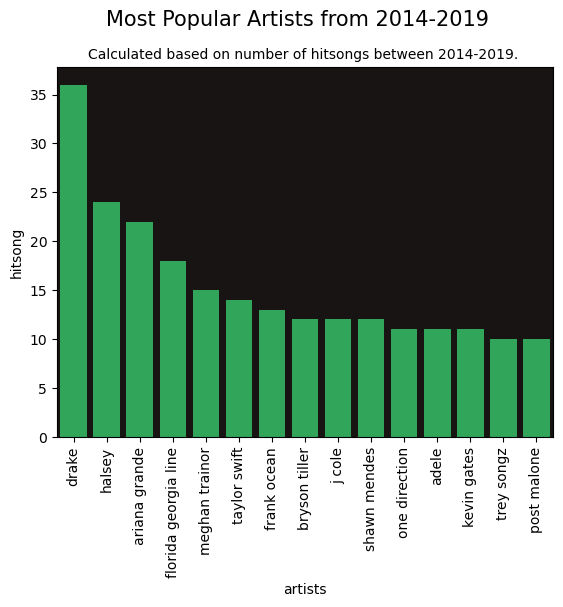

In [32]:
plt.rcParams.update(plt.rcParamsDefault)
x = song2019EDA.groupby("artists")["hitsong"].sum().sort_values(ascending = False).head(15)
ax = sns.barplot(x.index, x, color = '#1DB954')
ax.set_facecolor('#191414')

plt.suptitle('Most Popular Artists from 2014-2019', y=1, fontsize=15)
plt.title("Calculated based on number of hitsongs between 2014-2019. ", fontsize=10)
plt.xticks(rotation = 90)


# Drake also has the most songs though So popularity obs increases
#song2019EDA.groupby("artists")["track_name"].count().sort_values(ascending = False).head(15)



(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

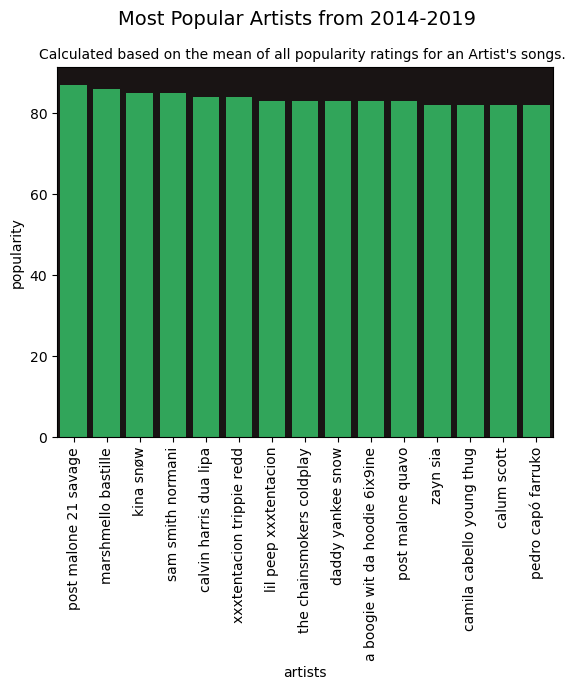

In [33]:
x = song2019EDA.groupby("artists")["popularity"].mean().sort_values(ascending = False).head(15)
ax = sns.barplot(x.index, x, color = '#1DB954')
ax.set_facecolor('#191414')

plt.suptitle('Most Popular Artists from 2014-2019', y=1, fontsize=14)
plt.title("Calculated based on the mean of all popularity ratings for an Artist's songs. ", fontsize=10)
plt.xticks(rotation = 90)


In [34]:
x = song2019EDA.groupby("artists")["hitsong"].sum().sort_values(ascending = False).head(15)
x

artists
drake                   36.0
halsey                  24.0
ariana grande           22.0
florida georgia line    18.0
meghan trainor          15.0
taylor swift            14.0
frank ocean             13.0
bryson tiller           12.0
j cole                  12.0
shawn mendes            12.0
one direction           11.0
adele                   11.0
kevin gates             11.0
trey songz              10.0
post malone             10.0
Name: hitsong, dtype: float64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

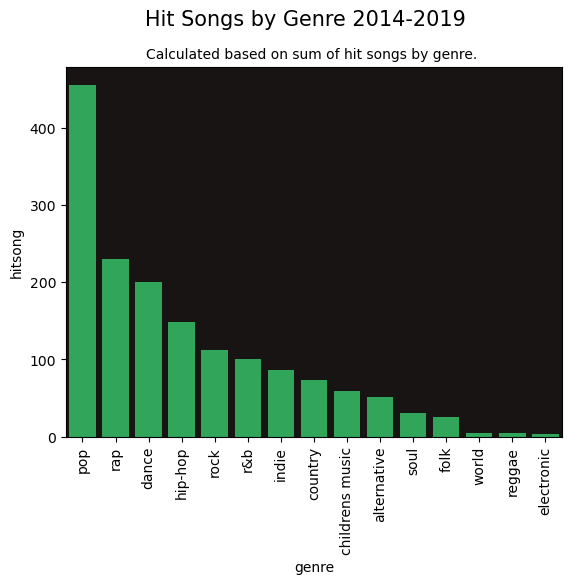

In [35]:
x = song2019EDA.groupby("genre")["hitsong"].sum().sort_values(ascending = False).head(15)
ax = sns.barplot(x.index, x ,color = '#1DB954')
ax.set_facecolor('#191414')

plt.suptitle('Hit Songs by Genre 2014-2019', y=1, fontsize=15)
plt.title("Calculated based on sum of hit songs by genre. ", fontsize=10)
plt.xticks(rotation = 90)

# shows genre by # of hit songs, most hit songs were pop genre


artists                   name                                     
trevor daniel             falling                                      92.0
travis scott              goosebumps                                   92.0
                          sicko mode                                   92.0
melanie martinez          play date                                    91.0
juice wrld                lucid dreams                                 89.0
xxxtentacion              jocelyn flores                               87.0
post malone 21 savage     rockstar feat 21 savage                      87.0
imagine dragons           believer                                     87.0
xxxtentacion              sad!                                         87.0
lady gaga bradley cooper  shallow                                      86.0
ed sheeran                perfect                                      86.0
post malone swae lee      sunflower  spiderman into the spiderverse    86.0
marshmello bastille 

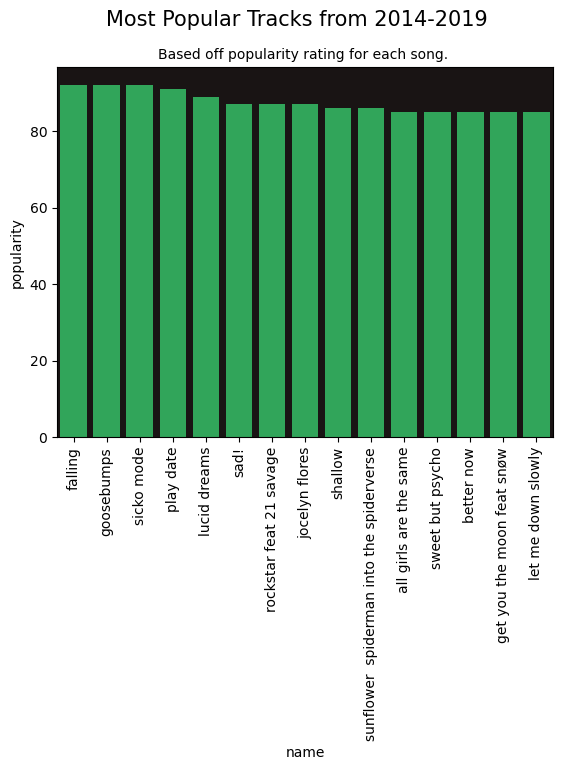

In [36]:
x = song2019EDA.groupby("name")["popularity"].mean().sort_values(ascending = False).head(15)
ax = sns.barplot(x.index, x ,color = '#1DB954')
ax.set_facecolor('#191414')

plt.suptitle('Most Popular Tracks from 2014-2019', y=1, fontsize=15)
plt.title("Based off popularity rating for each song. ", fontsize=10)
plt.xticks(rotation = 90)

song2019EDA.groupby(["artists", "name"])["popularity"].mean().sort_values(ascending = False).head(15)


artists                   name                                     
trevor daniel             falling                                      92.0
travis scott              goosebumps                                   92.0
                          sicko mode                                   92.0
melanie martinez          play date                                    91.0
juice wrld                lucid dreams                                 89.0
xxxtentacion              jocelyn flores                               87.0
post malone 21 savage     rockstar feat 21 savage                      87.0
imagine dragons           believer                                     87.0
xxxtentacion              sad!                                         87.0
lady gaga bradley cooper  shallow                                      86.0
ed sheeran                perfect                                      86.0
post malone swae lee      sunflower  spiderman into the spiderverse    86.0
marshmello bastille 

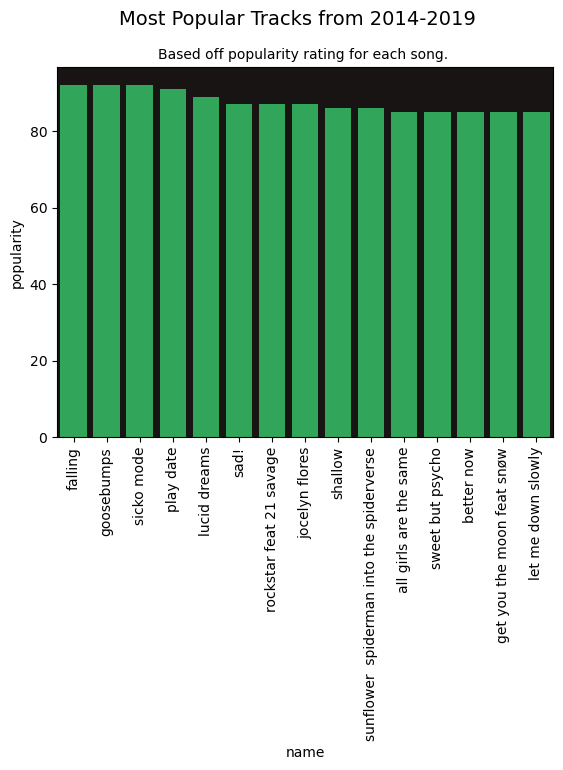

In [37]:
x = song2019EDA.groupby("name")["popularity"].mean().sort_values(ascending = False).head(15)
ax = sns.barplot(x.index, x ,color = '#1DB954')
ax.set_facecolor('#191414')

plt.suptitle('Most Popular Tracks from 2014-2019', y=1, fontsize=14)
plt.title("Based off popularity rating for each song. ", fontsize=10)
plt.xticks(rotation = 90)

song2019EDA.groupby(["artists", "name"])["popularity"].mean().sort_values(ascending = False).head(15)


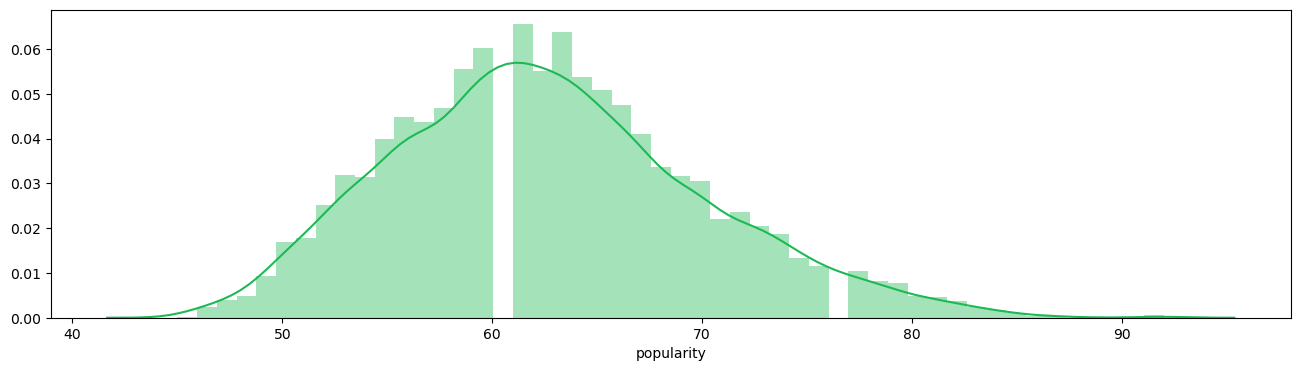

In [38]:
plt.figure(figsize=(16, 4))
sns.distplot(song2019EDA["popularity"],  color = "#1DB954")

In [39]:
# Correlation 
correlation_matrix = song2019.corr()
series = np.abs(correlation_matrix['highRate']).sort_values(ascending=False)
print('The most linear correlated features to POPULARITY are:')
for i, row in enumerate(series):
    if 0.05 <= row < 1:
        #print(series.index[i], round(series[i],2))
        print(f'{series.index[i]:17} --> {row: .2f} (abs)')

The most linear correlated features to POPULARITY are:
popularity        -->  0.80 (abs)
year_2018         -->  0.26 (abs)
year_2014         -->  0.23 (abs)
pop               -->  0.18 (abs)
hitsong           -->  0.14 (abs)
danceability      -->  0.13 (abs)
year_2015         -->  0.13 (abs)
year_2019         -->  0.12 (abs)
year_2017         -->  0.12 (abs)
duration_min      -->  0.08 (abs)
indie             -->  0.08 (abs)
year_2016         -->  0.08 (abs)
reggaeton         -->  0.08 (abs)
childrens music   -->  0.07 (abs)
instrumentalness  -->  0.07 (abs)
folk              -->  0.07 (abs)
dance             -->  0.07 (abs)
country           -->  0.06 (abs)
alternative       -->  0.06 (abs)
rock              -->  0.05 (abs)
loudness          -->  0.05 (abs)


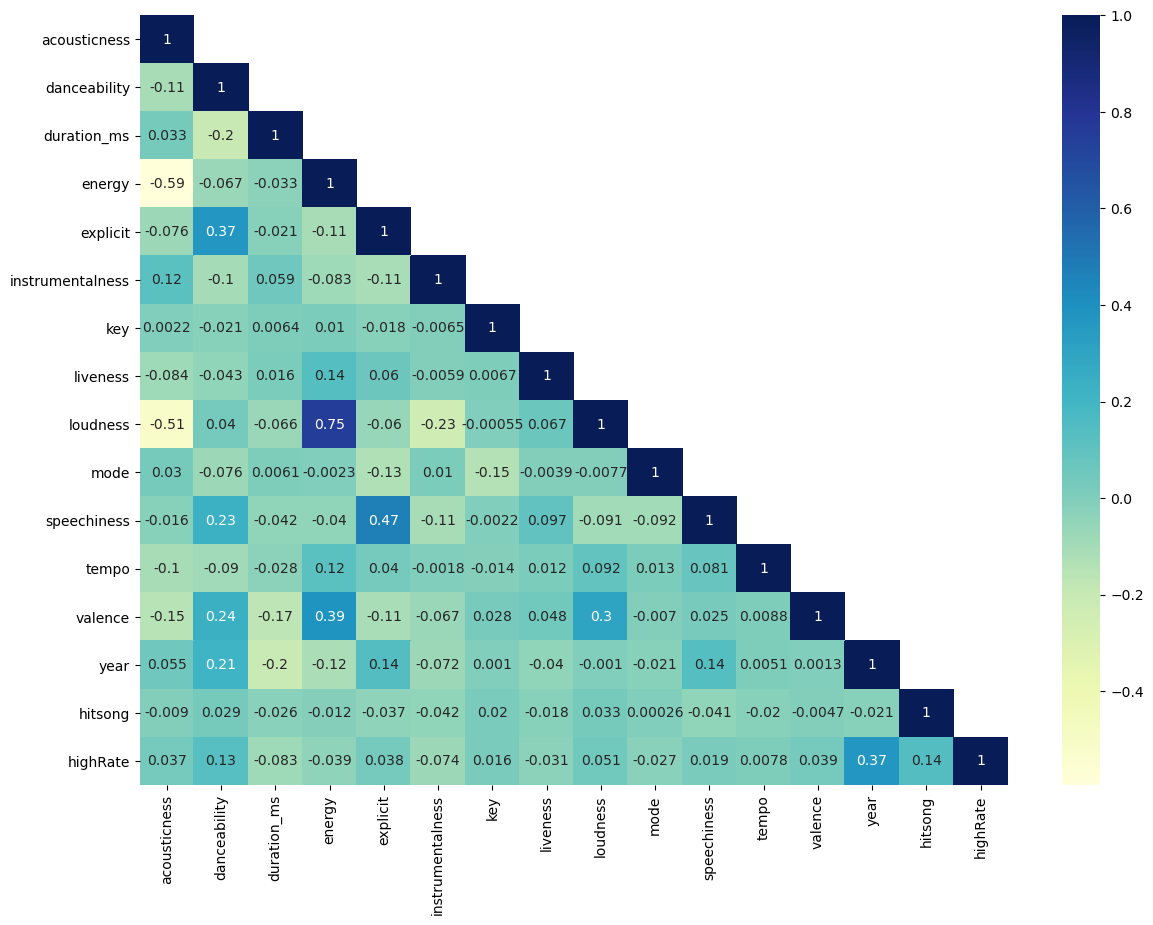

In [40]:
### correlation heatmap
plt.rcParams.update(plt.rcParamsDefault)
stdd = song2019EDA.drop(['genre', 'track_id', 'artists', 'name','popularity'], axis = 1)
corr = stdd.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask, 1)] = True
plt.figure(figsize=(14, 10))
sns.heatmap(corr,mask=mask,annot=True,cmap='YlGnBu')
plt.show()

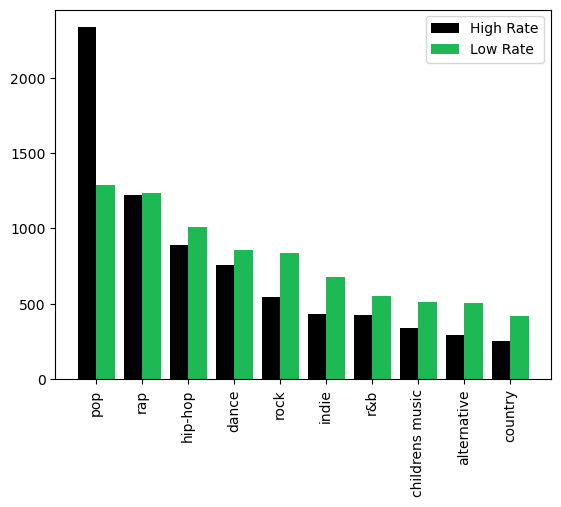

In [41]:
high = song2019EDA[song2019EDA.highRate==1].groupby('genre').genre.count().sort_values(ascending=False).head(10)
low = song2019EDA[song2019EDA.highRate==0].groupby('genre').genre.count().sort_values(ascending=False).head(10)
X = list(high.index)
Y = list(high)
Z = list(low)
_X = np.arange(len(X))


plt.bar(_X - 0.2, Y, 0.4, label='High Rate', color = "black")
plt.bar(_X + 0.2, Z, 0.4, label='Low Rate', color = "#1DB954")
plt.xticks(_X, X) 
plt.xticks(rotation = 90)
plt.legend()
#plt.savefig('b.png',bbox_inches = "tight")
plt.show()

In [42]:
fea_dif = df[(df.year >= 2014) & (df.year < 2020)]
fea_dif['highRate'] = np.where(fea_dif.popularity > 62, 1, 0)
fea_dif = fea_dif.drop(['popularity','genre','year'], axis=1)
fea_dif['highRate'] = fea_dif.highRate.astype('int')
fea_dif = fea_dif.groupby('highRate').mean()
fea_dif = fea_dif.T.reset_index()
fea_dif.columns = ['genre','Not Popular','Popular']
fea_dif['Percentage Change %'] = ((abs(fea_dif.iloc[:,2] - fea_dif.iloc[:,1])) 
                                / abs(fea_dif.iloc[:,1]))*100
fea_dif = fea_dif.set_index('genre')
fea_dif.sort_values(by='Percentage Change %',ascending = False)
fea_dif

,Not Popular,Popular,Percentage Change %
genre,,,
acousticness,0.215912,0.234719,8.710782
danceability,0.614144,0.651891,6.146146
duration_ms,226500.257007,217887.326921,3.802614
energy,0.632306,0.617821,2.290733
explicit,0.405953,0.443108,9.152596
instrumentalness,0.032957,0.016335,50.435634
key,5.136553,5.252120,2.249891
liveness,0.182914,0.174426,4.640387
loudness,-6.931887,-6.651304,4.047705


In [43]:
# select dataset for music features
from sklearn.preprocessing import StandardScaler
gfeature = song2019EDA[['acousticness','danceability','duration_ms','energy','explicit',
                                            'instrumentalness','key','liveness','loudness','mode','speechiness',
                                            'tempo','valence']]
std = StandardScaler().fit(gfeature).transform(gfeature)
genrefeature = pd.DataFrame(std)
genrefeature.columns = (list(gfeature))
ftemp = song2019EDA['genre'].reset_index().drop(['index'], axis = 1)
genrefeature['genre'] = ftemp

In [44]:
# plot the stack bar graph
import heapq
gfeature = genrefeature.groupby('genre').mean().abs()
total = gfeature.sum(axis=1)
for i in list(gfeature):
    gfeature[i] = gfeature[i]/total
for i in list(gfeature.index):
    low = heapq.nsmallest(10, gfeature.loc[i])
    gfeature.loc[i][gfeature.loc[i].isin(low)] = 0

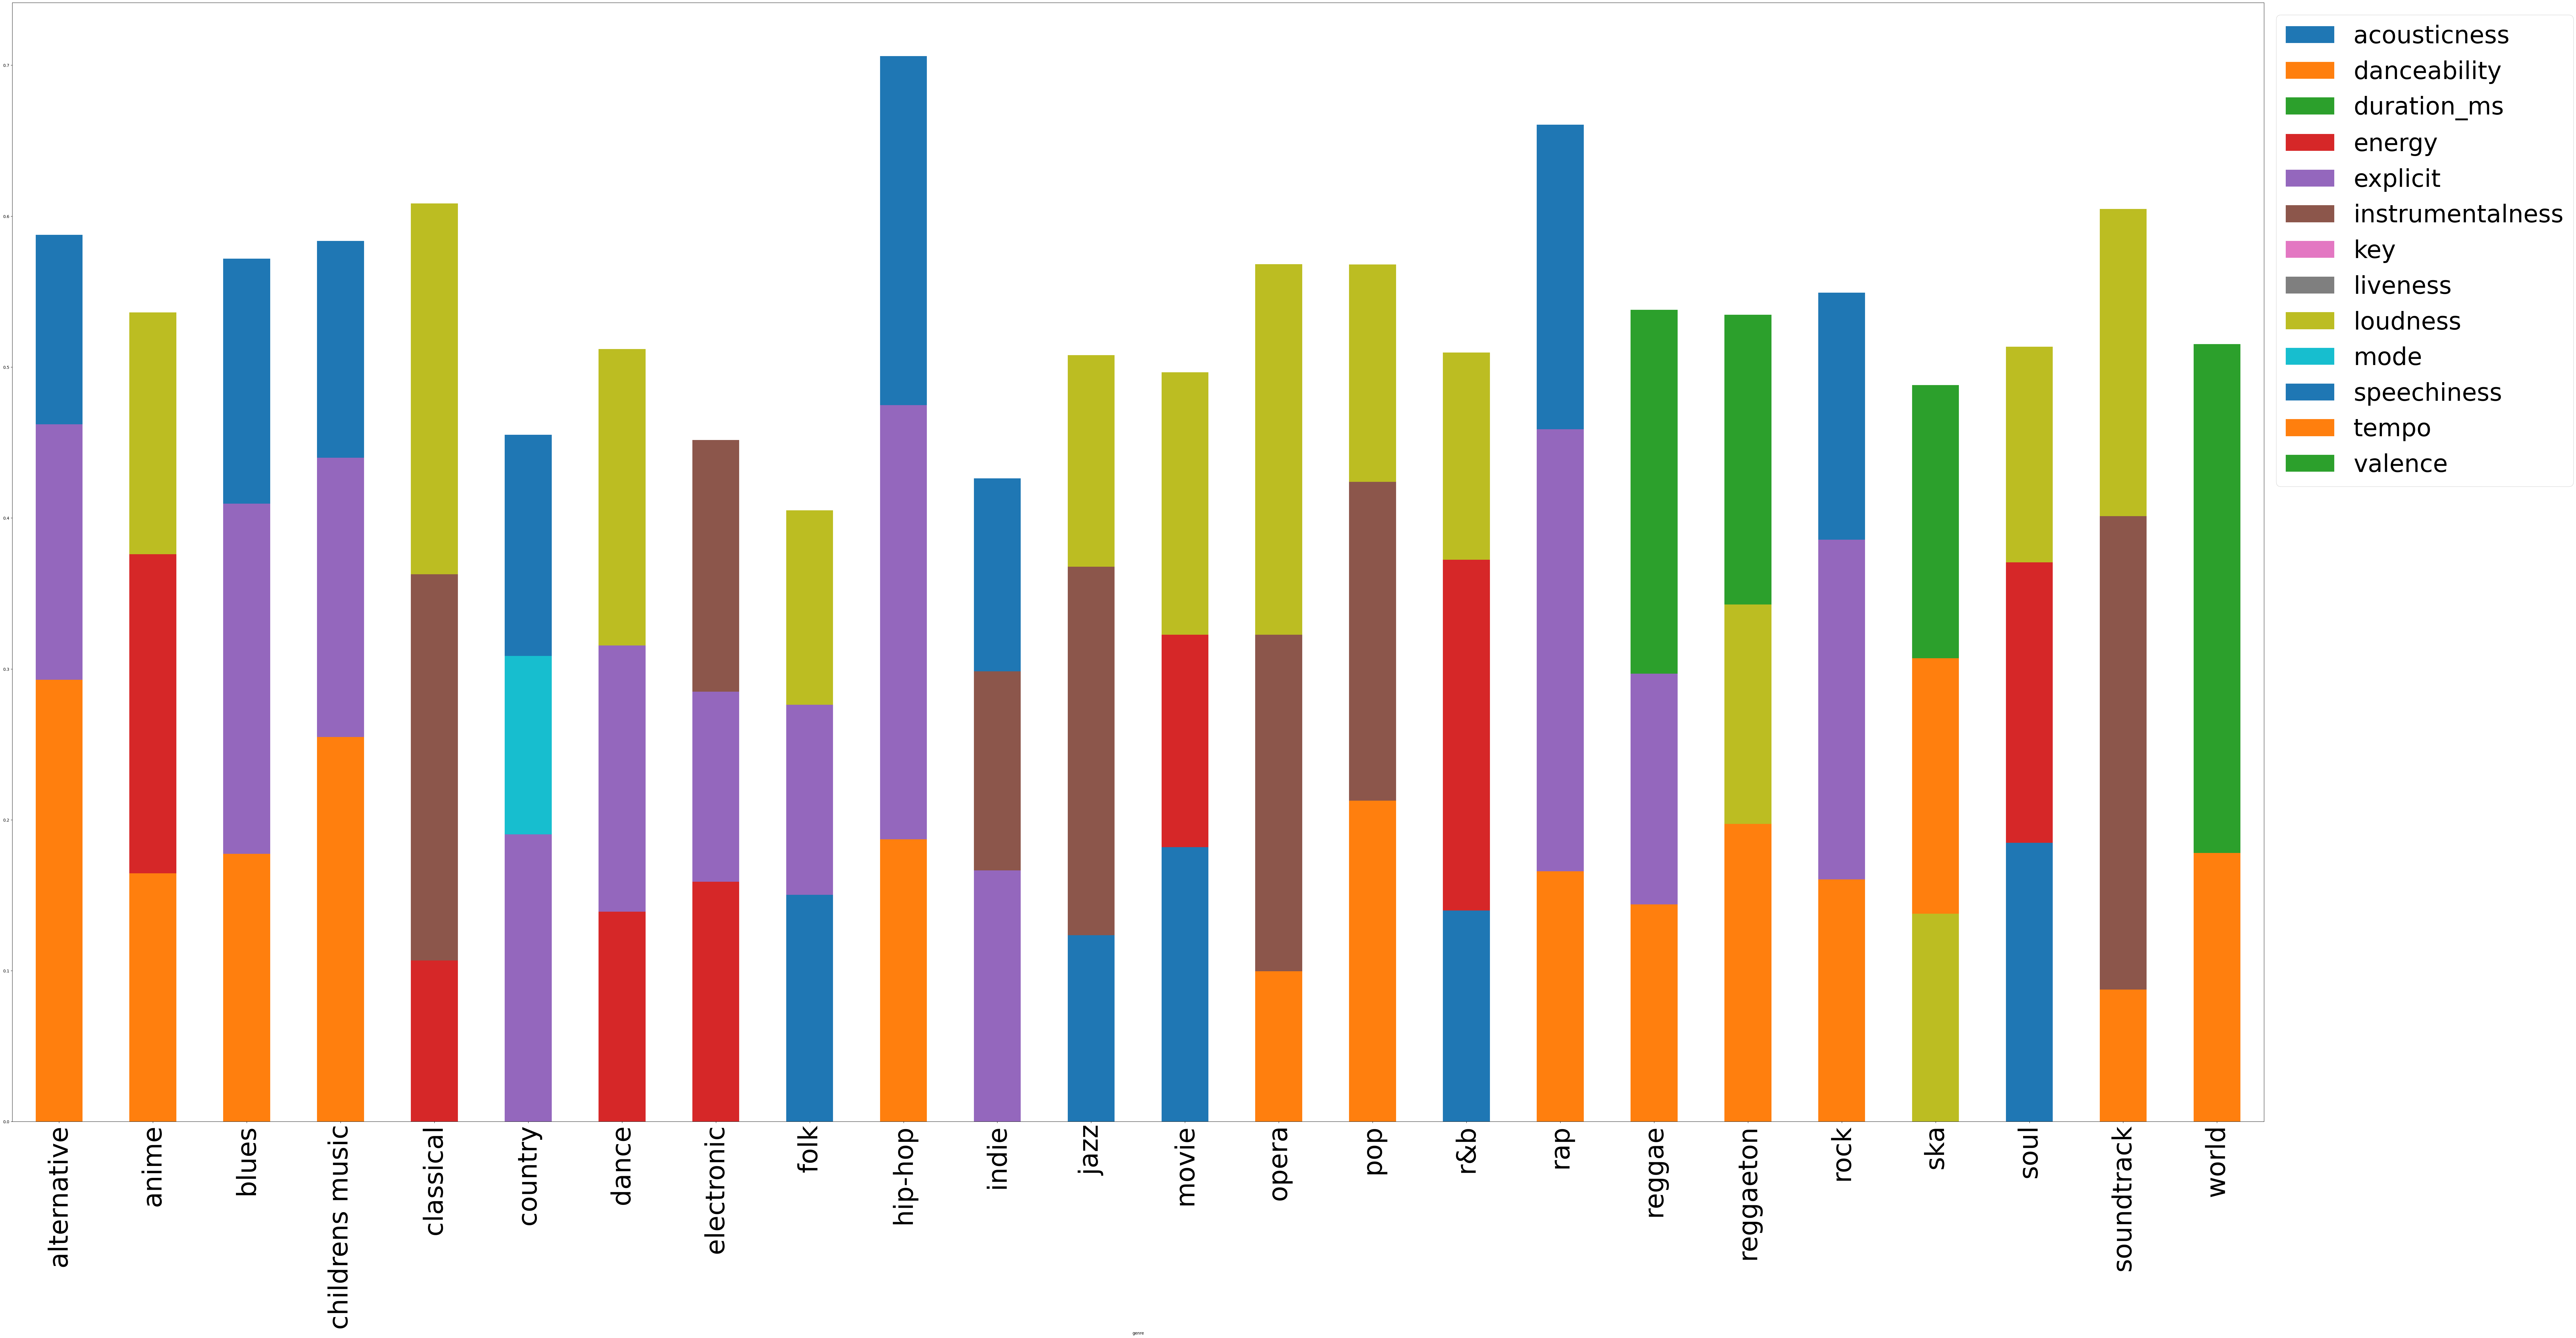

In [45]:
# plot 
gfeature.plot.bar(stacked=True, figsize=(100,50))
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize = 60)
plt.xticks(fontsize=65)
plt.show()

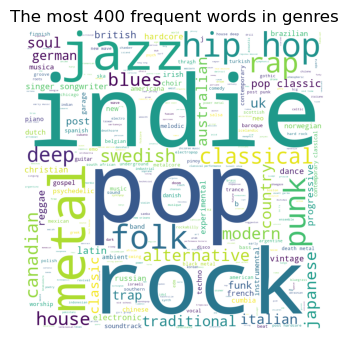

In [46]:
from wordcloud import WordCloud 

max_words = 400
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', max_words = max_words, colormap="viridis",
                min_font_size = 5).generate(" ".join(genre1.genres))

plt.figure(figsize=(3,3))
plt.imshow(wordcloud)
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title(f"The most {max_words} frequent words in genres")
plt.show()
#plt.savefig('d.png',bbox_inches = "tight")


# Pop, Indie, Rock are the most popular?

In [47]:
allhits = song[song["highRate"] == 1]

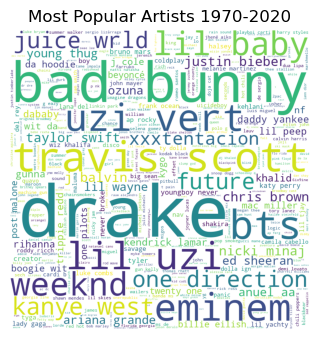

In [48]:
from wordcloud import WordCloud 

max_words = 400
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', max_words = max_words, colormap="viridis",
                min_font_size = 5).generate(" ".join(allhits.artists))

plt.figure(figsize=(3,3))
plt.imshow(wordcloud)
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title(f"Most Popular Artists 1970-2020")
#plt.savefig('c.png',bbox_inches = "tight")
plt.show()

# all time results

In [49]:
hit2019 = song2019EDA[song2019EDA["highRate"] == 1]

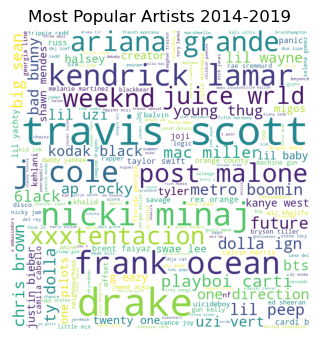

In [50]:
from wordcloud import WordCloud 

max_words = 200
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', max_words = max_words, colormap="viridis",
                min_font_size = 5).generate(" ".join(hit2019.artists))

plt.figure(figsize=(3,3))
plt.imshow(wordcloud)
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title(f"Most Popular Artists 2014-2019")
#plt.savefig('c.png',bbox_inches = "tight")
plt.show()

# 2014-2019 results

In [51]:
song2019EDA.groupby("artists")["highRate"].count().sort_values(ascending=False)

artists
drake                           180
frank ocean                     118
j cole                          100
$uicideboy$                      85
kevin gates                      85
                               ... 
damian marley stephen marley      1
dagames                           1
dae dae                           1
myke towers farruko               1
kygo ella henderson               1
Name: highRate, Length: 3331, dtype: int64

In [52]:
song.groupby("artists")["popularity"].count().sort_values(ascending=False)

artists
queen                              426
fleetwood mac                      336
bob marley & the wailers           292
led zeppelin                       268
elton john                         259
                                  ... 
mandisa tobymac kirk franklin        1
mandisa tobymac                      1
mandingo josé guadalupe esparza      1
manchild                             1
$imeon                               1
Name: popularity, Length: 22960, dtype: int64

#### For 2019 Only

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

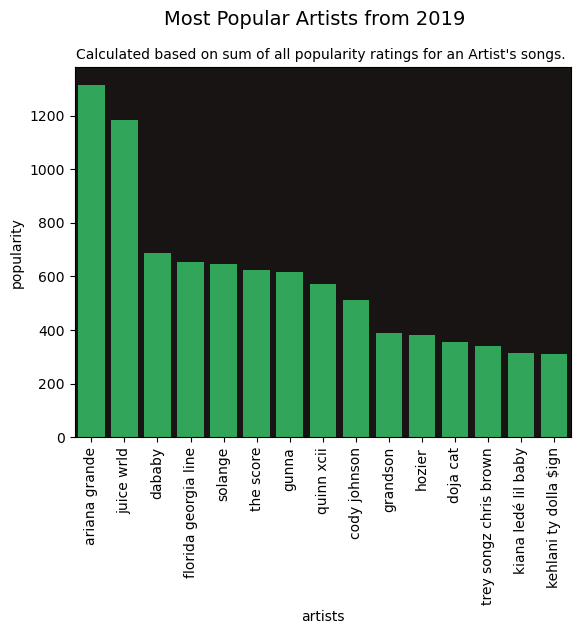

In [53]:
x = only2019.groupby("artists")["popularity"].sum().sort_values(ascending = False).head(15)
ax = sns.barplot(x.index, x, color = '#1DB954')
ax.set_facecolor('#191414')

plt.suptitle('Most Popular Artists from 2019', y=1, fontsize=14)
plt.title("Calculated based on sum of all popularity ratings for an Artist's songs. ", fontsize=10)
plt.xticks(rotation = 90)


# Drake also has the most songs though So popularity obs increases
#song2019EDA.groupby("artists")["track_name"].count().sort_values(ascending = False).head(15)



(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

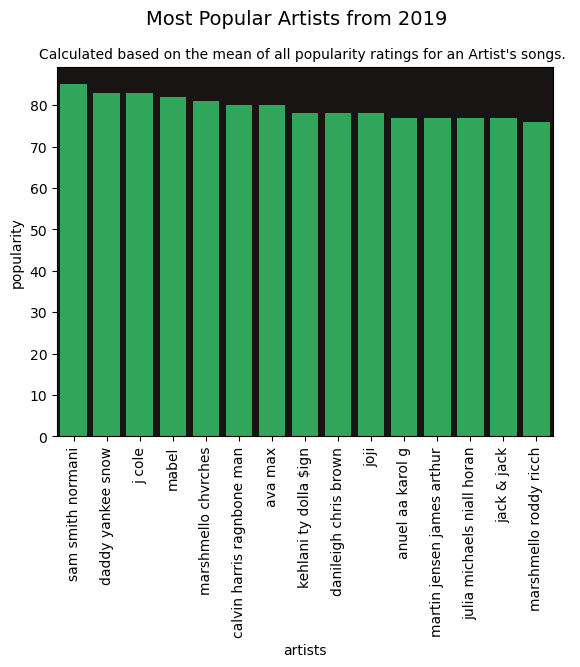

In [54]:
x = only2019.groupby("artists")["popularity"].mean().sort_values(ascending = False).head(15)
ax = sns.barplot(x.index, x, color = '#1DB954')
ax.set_facecolor('#191414')

plt.suptitle('Most Popular Artists from 2019', y=1, fontsize=14)
plt.title("Calculated based on the mean of all popularity ratings for an Artist's songs. ", fontsize=10)
plt.xticks(rotation = 90)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

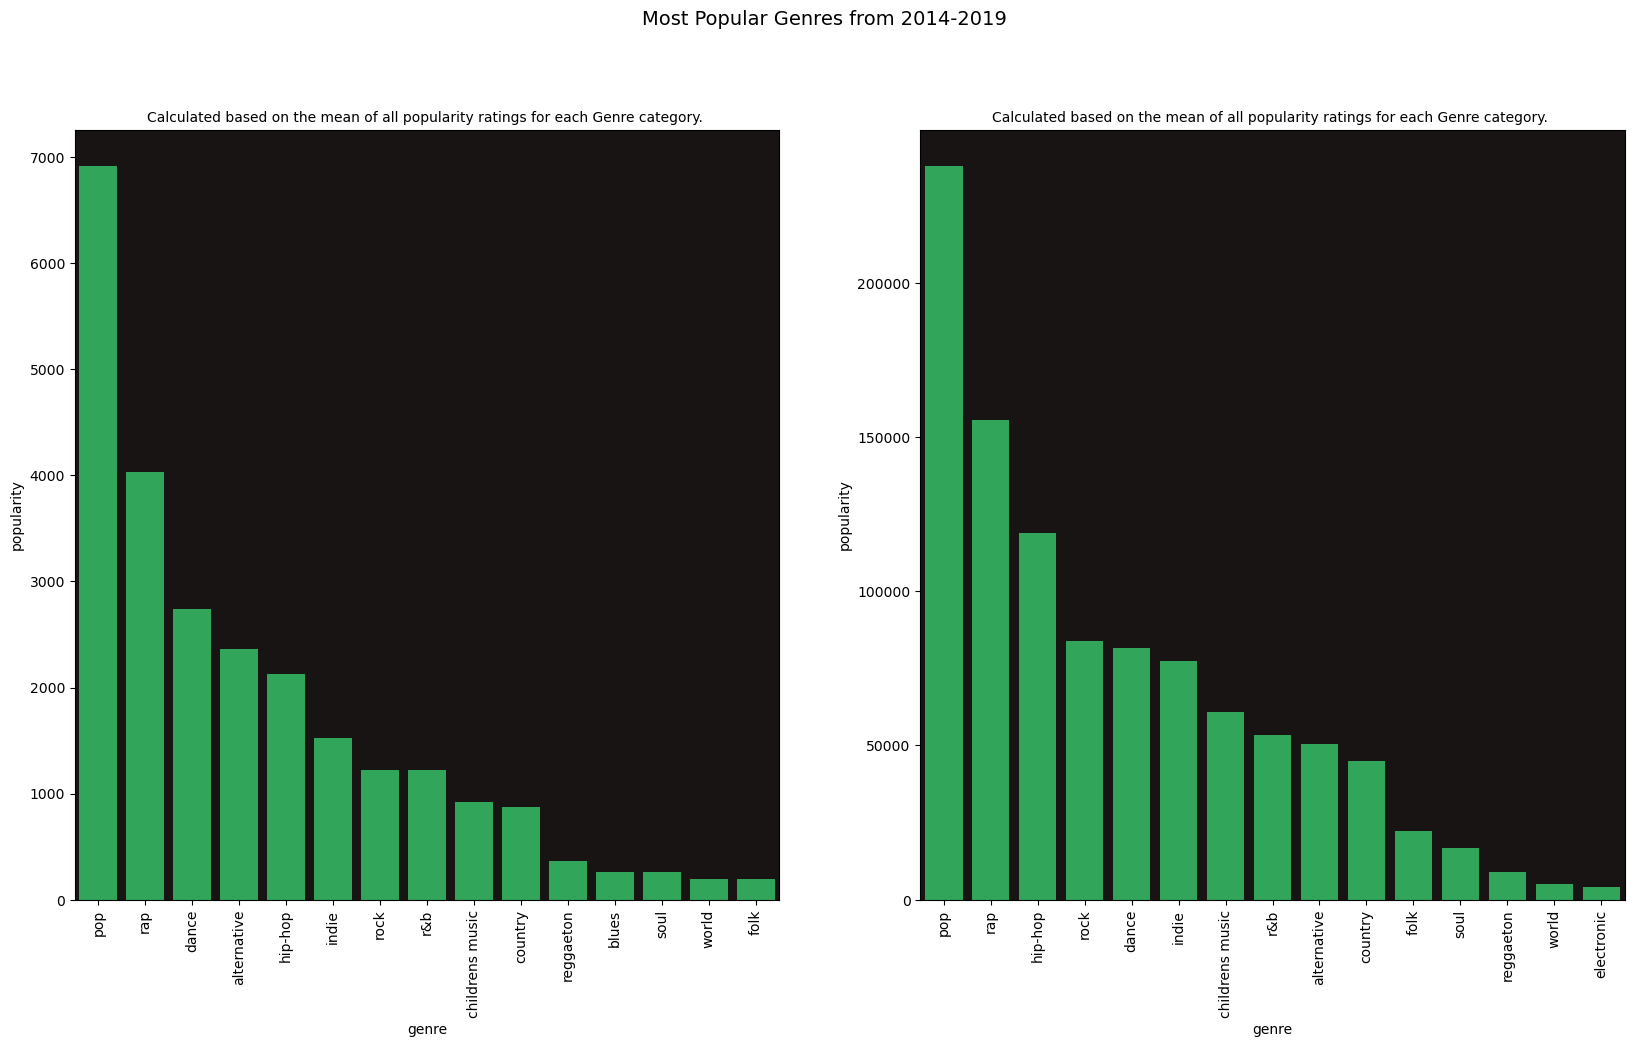

In [55]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
x = only2019.groupby("genre")["popularity"].sum().sort_values(ascending = False).head(15)
ax = sns.barplot(x.index, x ,color = '#1DB954')
ax.set_facecolor('#191414')
plt.title("Calculated based on the mean of all popularity ratings for each Genre category. ", fontsize=10)
plt.xticks(rotation = 90)


plt.subplot(1, 2, 2)
x = song2019EDA.groupby("genre")["popularity"].sum().sort_values(ascending = False).head(15)
ax = sns.barplot(x.index, x ,color = '#1DB954')
ax.set_facecolor('#191414')
plt.suptitle('Most Popular Genres from 2014-2019', y=1, fontsize=14)
plt.title("Calculated based on the mean of all popularity ratings for each Genre category. ", fontsize=10)
plt.xticks(rotation = 90)


## FIX TITLES


artists                     name                                  
sam smith normani           dancing with a stranger with normani      85.0
daddy yankee snow           con calma                                 83.0
j cole                      middle child                              83.0
dababy                      suge                                      82.0
mabel                       dont call me up                           82.0
marshmello chvrches         here with me                              81.0
ariana grande               break up with your girlfriend im bored    81.0
ava max                     so am i                                   80.0
calvin harris ragnbone man  giant with ragnbone man                   80.0
joji                        sanctuary                                 78.0
kehlani ty dolla $ign       nights like this feat ty dolla $ign       78.0
danileigh chris brown       easy  remix                               78.0
juice wrld                  fast 

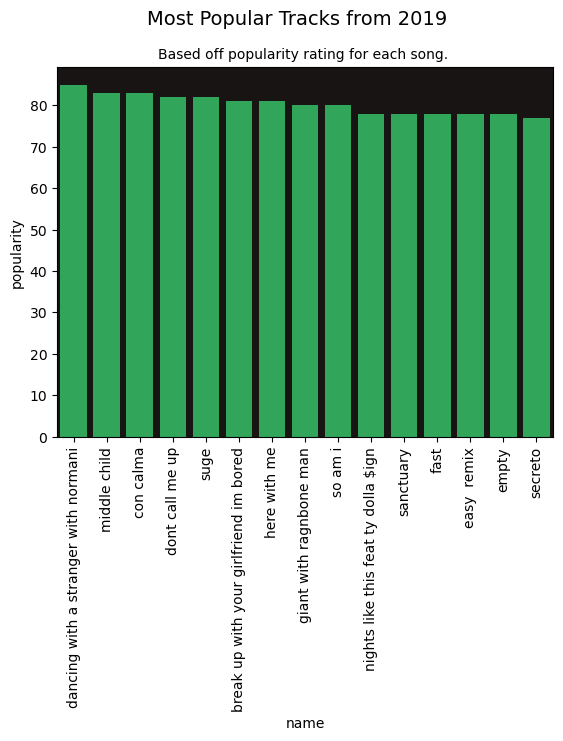

In [56]:
x = only2019.groupby("name")["popularity"].mean().sort_values(ascending = False).head(15)
ax = sns.barplot(x.index, x ,color = '#1DB954')
ax.set_facecolor('#191414')

plt.suptitle('Most Popular Tracks from 2019', y=1, fontsize=14)
plt.title("Based off popularity rating for each song. ", fontsize=10)
plt.xticks(rotation = 90)

only2019.groupby(["artists", "name"])["popularity"].mean().sort_values(ascending = False).head(15)

In [57]:
hit2019only = only2019[only2019["highRate"] == 1]

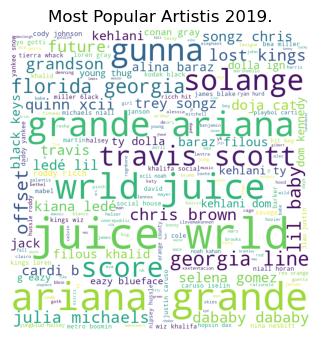

In [58]:
from wordcloud import WordCloud 

max_words = 200
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', max_words = max_words, colormap="viridis",
                min_font_size = 5).generate(" ".join(hit2019only.artists))

plt.figure(figsize=(3,3))
plt.imshow(wordcloud)
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title(f"Most Popular Artistis 2019.")
#plt.savefig('d.png',bbox_inches = "tight")

plt.show()


# 2019 results

## Logistic Regression

In [155]:
# split the data 
from sklearn.model_selection import train_test_split
song2019 = song2019.drop(['popularity'], axis=1)
X = song2019.drop('highRate', axis=1)
y = song2019['highRate']
x_train,x_test,y_train,y_test = train_test_split(song2019.drop(['highRate'], axis=1), 
                                                 song2019['highRate'], test_size = 0.3,random_state = 1)

In [163]:
# build logistic regression model
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV(random_state = 0, cv=10).fit(X, y)
y_pred = clf.predict(X)

In [164]:
# Ignore warning
import warnings 
warnings.filterwarnings('ignore')

# Check accuracy rate for logistic regreesion 10-fold cross validation model 
from sklearn.metrics import accuracy_score
print ('Accuracy is', accuracy_score(y,y_pred))
from sklearn.metrics import precision_score
print ('Precesion is', precision_score(y,y_pred))
from sklearn.metrics import recall_score
print ('Recall is', recall_score(y,y_pred))

Accuracy is 0.6790444511641972
Precesion is 0.6938714499252616
Recall is 0.5875205670168333


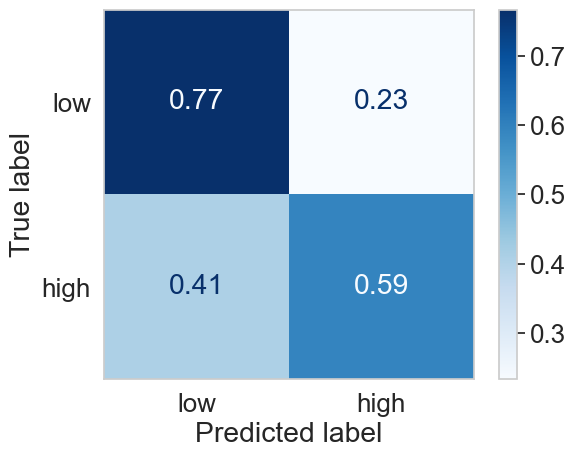

In [165]:
# confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, X, y, display_labels=['low','high'], normalize='true',cmap=plt.cm.Blues)
plt.grid(False)

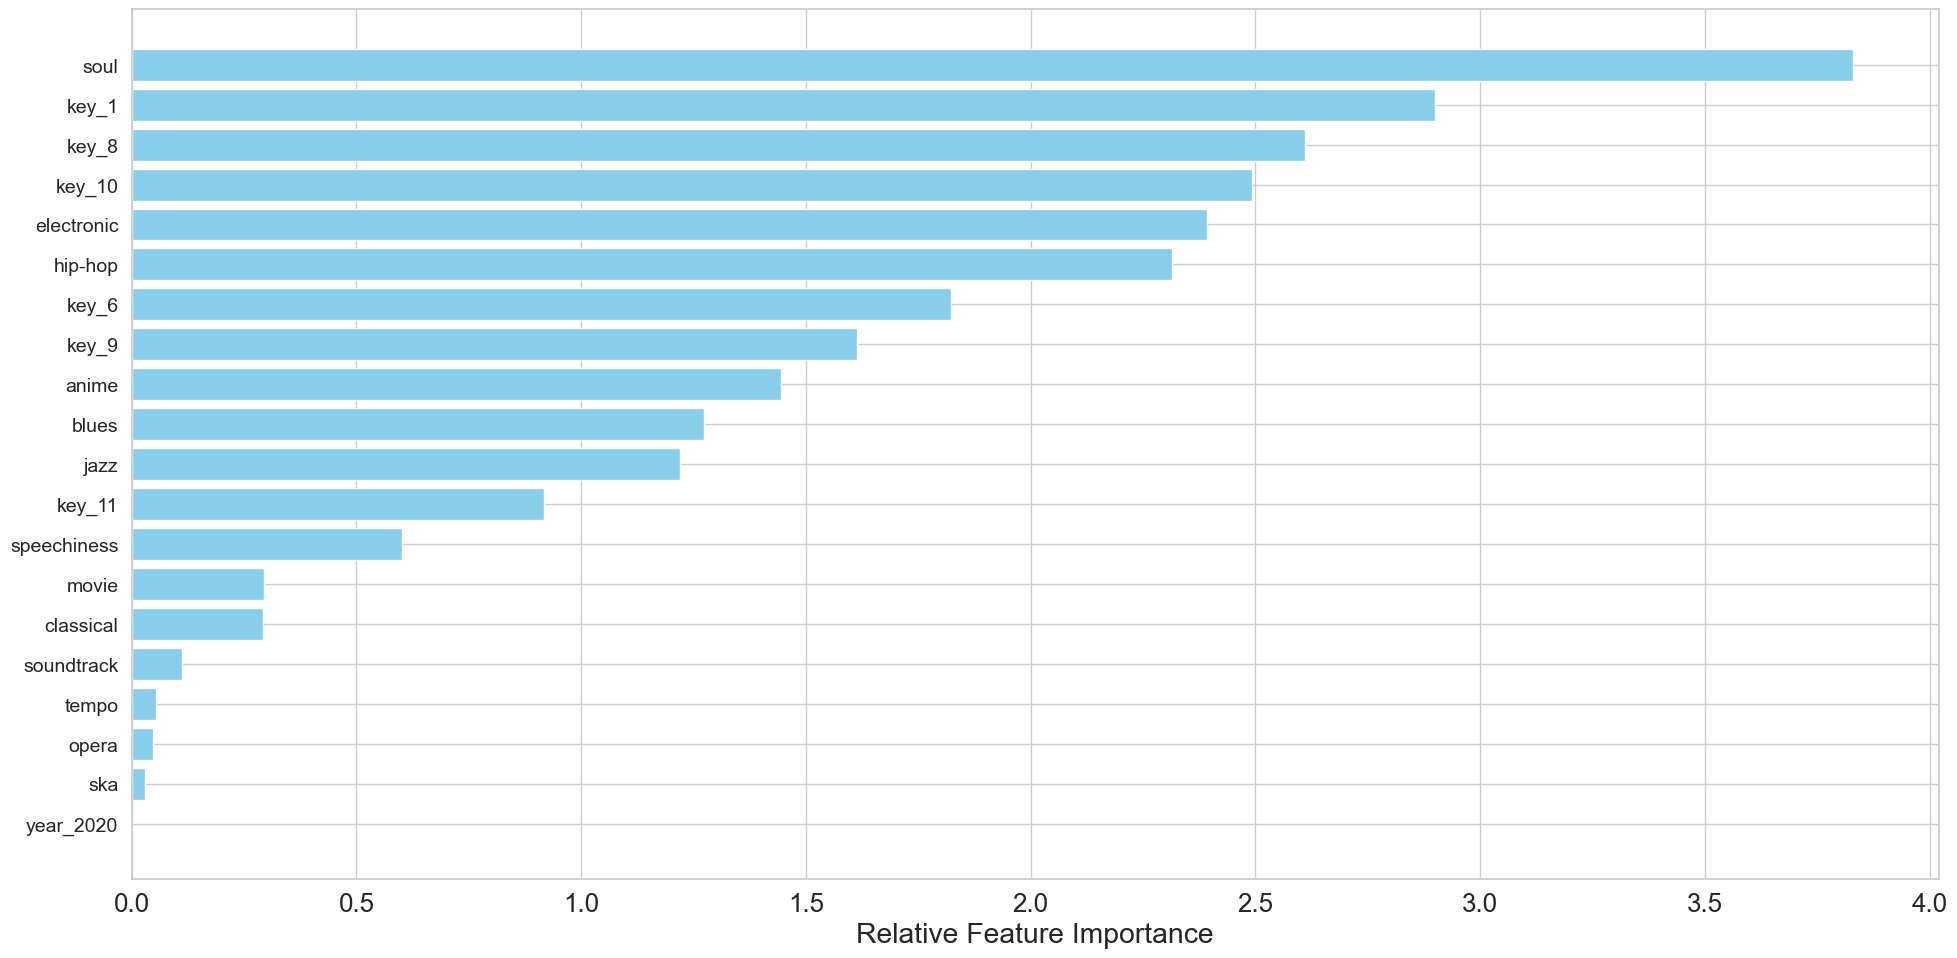

In [166]:
# plot feature importance
feature_importance = abs(clf.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[0:20]
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(20,10))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center', color='skyblue')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=14)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

## Features Cross and Selection & Logistic Regression

In [167]:
#from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree = 2,interaction_only = False)
songfeatures = poly.fit_transform(X)
x_train1,x_test1,y_train1,y_test1 = train_test_split(songfeatures,y,test_size = 0.3,
                                                     random_state = 1)

In [168]:
# run logistic regression model using 10-fold cross validation
# penalty = l1 -> feature selection
clf2 = LogisticRegressionCV(penalty = 'l1',random_state = 0, solver='liblinear', 
                            cv=10).fit(songfeatures, y)
y_pred2 = clf2.predict(songfeatures)

In [169]:
# check accuracy for Polynomial feature and logistic regression 
from sklearn.metrics import accuracy_score
print ('Accuracy is', accuracy_score(y,y_pred2))
from sklearn.metrics import precision_score
print ('Precesion is', precision_score(y,y_pred2))
from sklearn.metrics import recall_score
print ('Recall is', recall_score(y,y_pred2))

Accuracy is 0.6826126398548533
Precesion is 0.6878629089364112
Recall is 0.6147323123655234


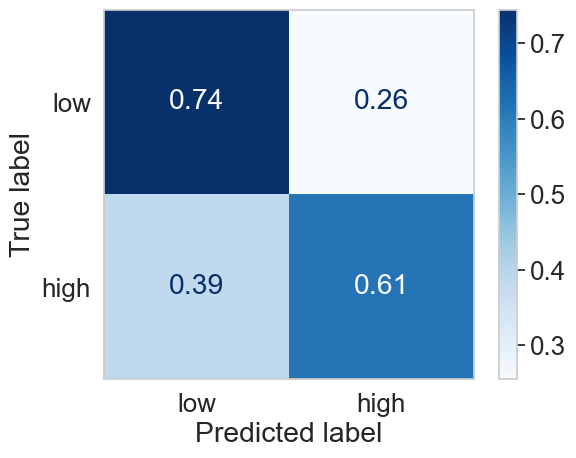

In [170]:
# plot confusion matrix 
plot_confusion_matrix(clf2, songfeatures, y,
                      display_labels=['low','high'],normalize='true',
                      cmap=plt.cm.Blues)
plt.grid(False)

## Random Forest

In [130]:
# import decision tree package 
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

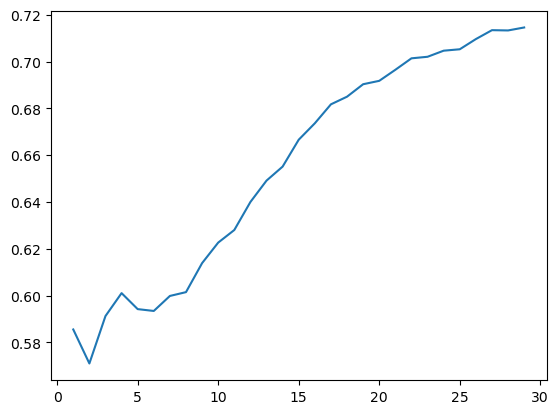

In [105]:
# Find out the optimal tree depth = 4 
# cv = 10 means 10-fold cross validation
a=[]
b=[]
for i in range (1,30):
    clf = tree.DecisionTreeClassifier(max_depth=i)
    clf = clf.fit(x_train1, y_train1)
    scores = cross_val_score(clf ,X, y, None,'accuracy',cv=10)
    a.append(i)
    b.append(np.array(scores).mean()) 
plt.plot(a, b)
plt.show()

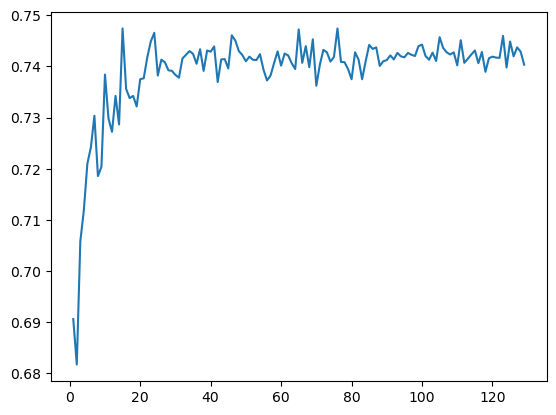

In [119]:
# find the optimal number of trees for random forest 
a=[]
b=[]
for i in range(1,130):
    clf = RandomForestClassifier(n_estimators=i, max_features='sqrt', criterion='entropy')
    clf = clf.fit(x_train1, y_train1)
    scores = cross_val_score(clf, songfeatures, y, None,'accuracy',cv=10)
    a.append(i)
    b.append(np.array(scores).mean()) 
plt.plot(a, b)
plt.show()

In [171]:
# Build random forest model
# import package
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=20, max_features='sqrt', criterion='entropy')
rfc = rfc.fit(x_train1, y_train1)

In [179]:
# Check accuracy score for cross validation
from sklearn.model_selection import cross_val_score

scores1 = cross_val_score(rfc, songfeatures, y, cv = 10, scoring = 'accuracy').mean()
print('Average accuracy: ', scores1)
scores2 = cross_val_score(rfc, songfeatures, y, cv = 10, scoring = 'precision').mean()
print('Average precision: ', scores2)
scores3 = cross_val_score(rfc, songfeatures, y, cv = 10, scoring = 'recall').mean()
print('Average recall: ', scores3)

Average accuracy:  0.7373734392270548
Average precision:  0.7633240711807856
Average recall:  0.735869513034294


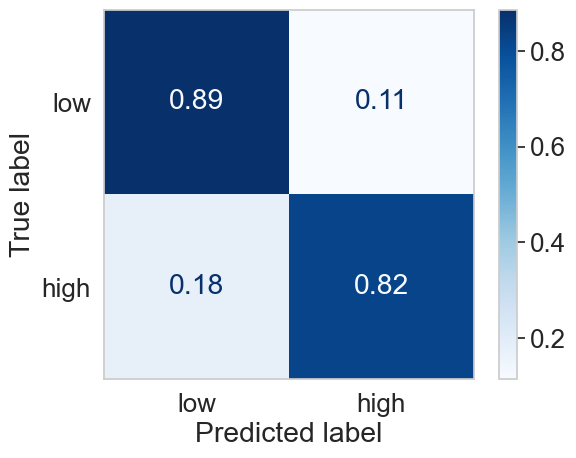

In [173]:
# plot confusion matrix on testing data
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(rfc, x_test1, y_test1, display_labels=['low','high'], normalize='true',cmap=plt.cm.Blues)
plt.grid(False)

In [174]:
# feature importance
feats = {}
for feature, importance in zip(X.columns, rfc.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Entropy_Importance'})
importances = importances.sort_values(by='Entropy_Importance', ascending=False).reset_index().rename(columns={'index': 'Features'})

In [175]:
# top 20 importances
importances_top = importances.iloc[0:21,:]
importances_top

,Features,Entropy_Importance
0,alternative,0.008200
1,tempo,0.007764
2,loudness,0.007758
3,explicit,0.007629
4,hitsong,0.007462
5,danceability,0.007155
6,mode,0.006944
7,valence,0.006944
8,energy,0.006647
9,year_2015,0.005619


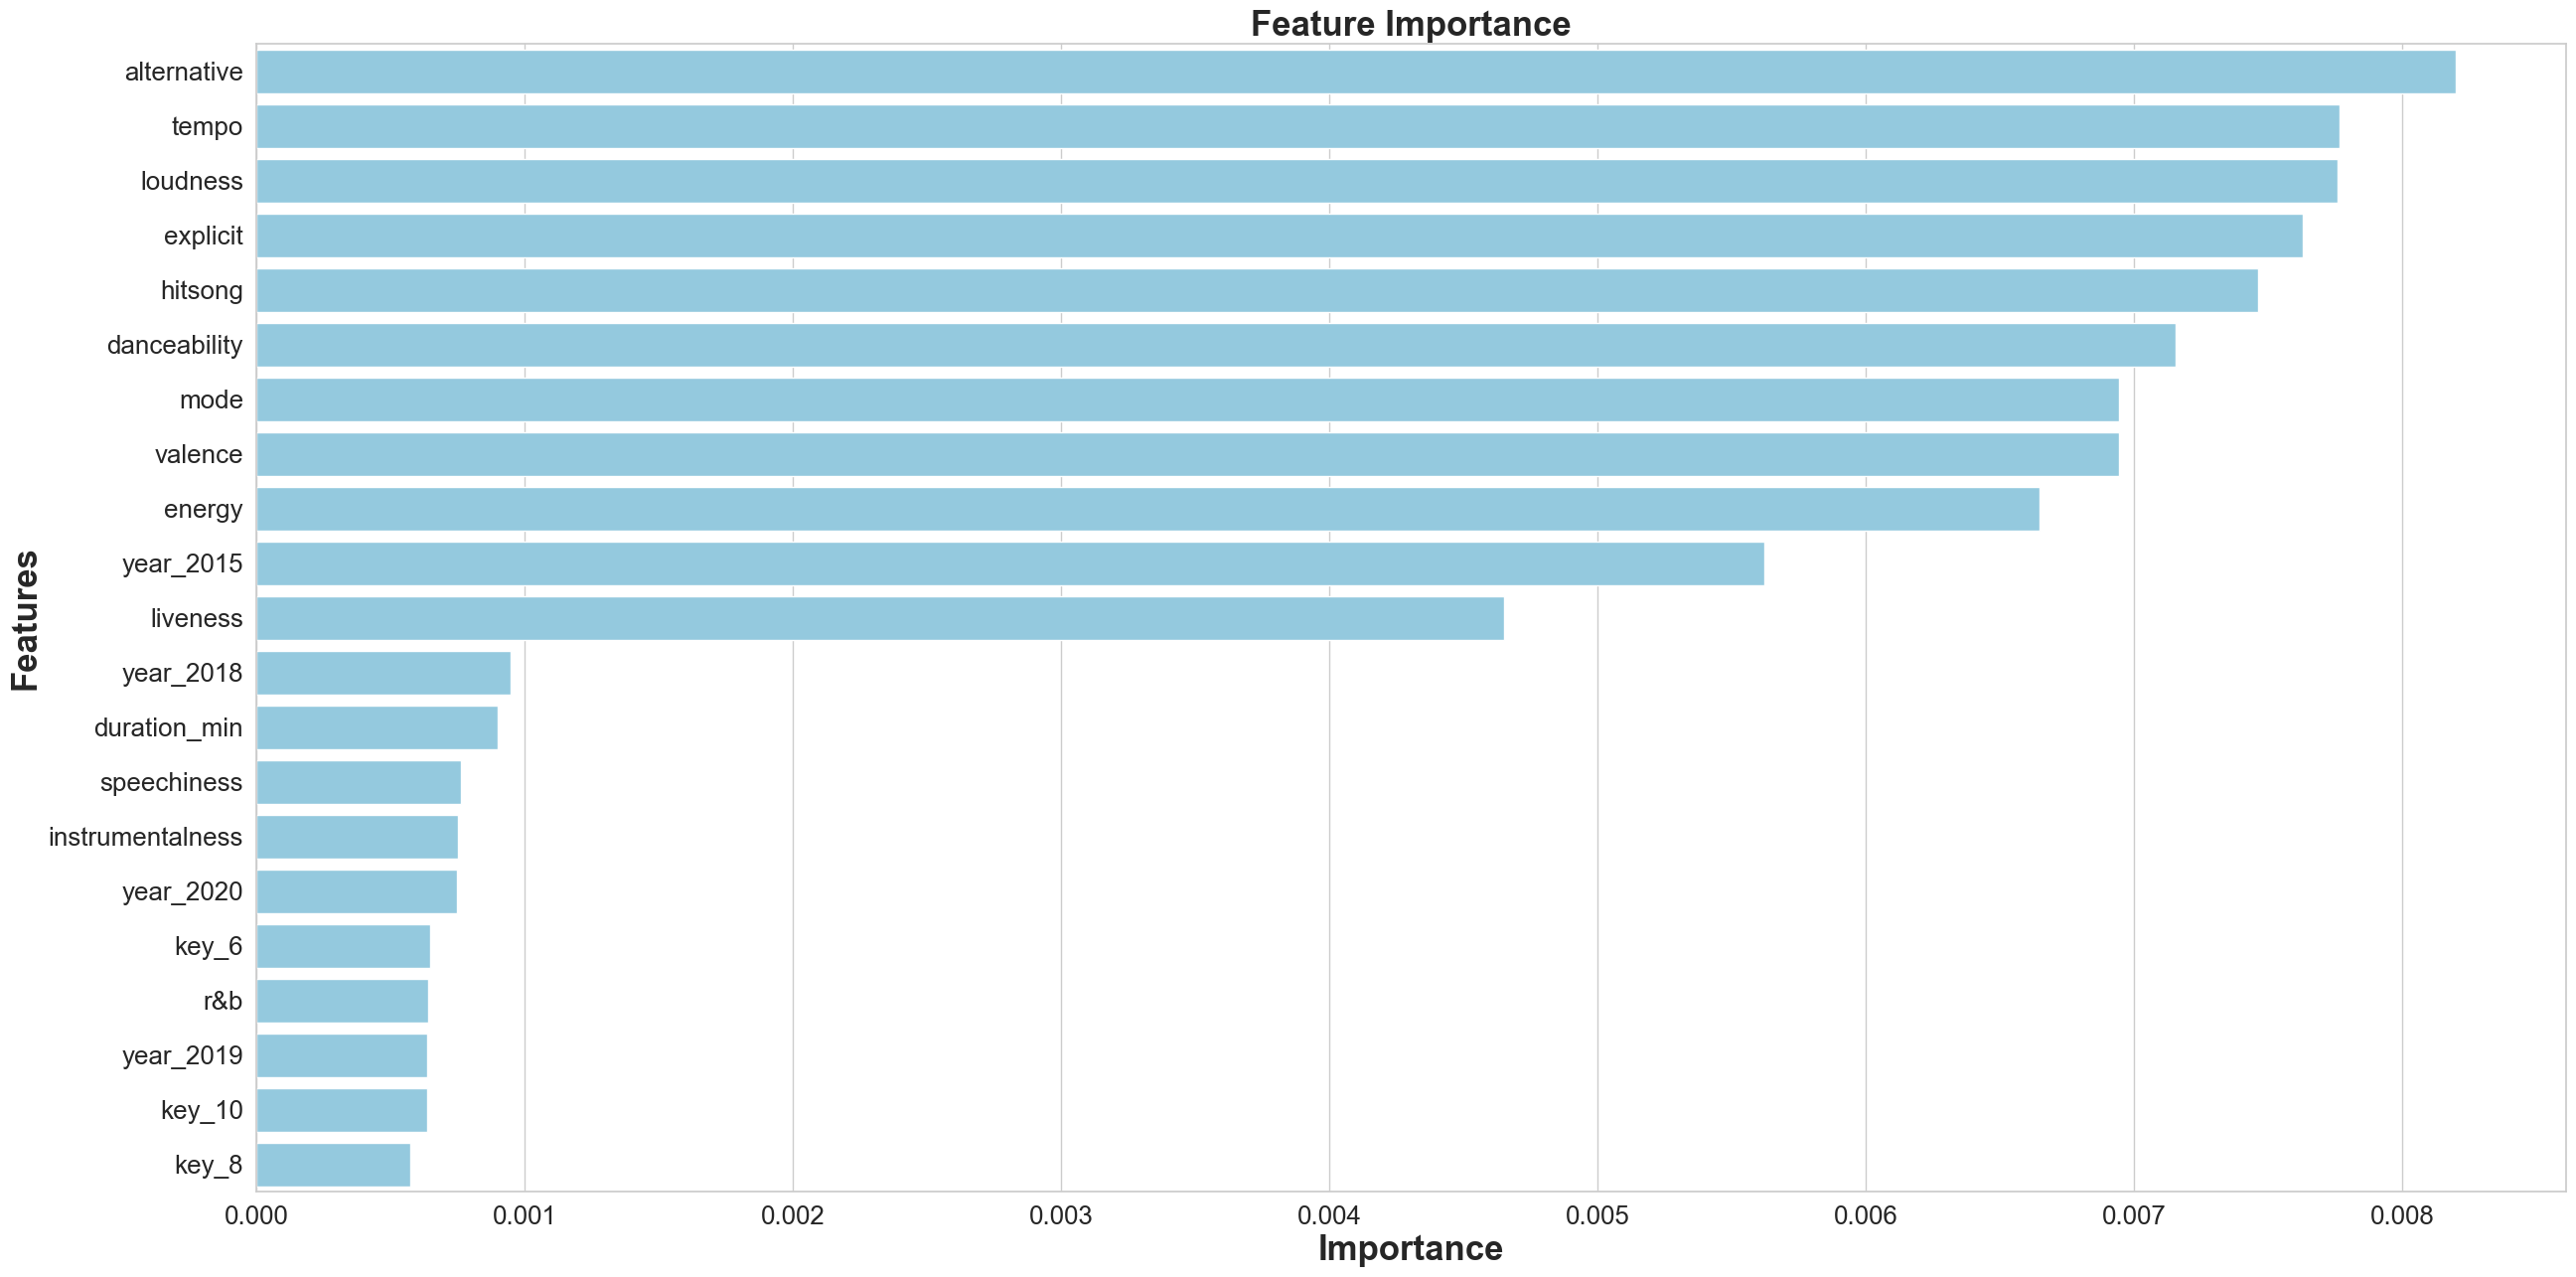

In [176]:
# plot the most important features for variable selection & Random forest
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances_top['Entropy_Importance'], y=importances_top['Features'], data=importances_top, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
plt.show()

In [ ]:
#tree.export_text(rfc.estimators_[0], feature_names=list(X))

In [ ]:
# plot the second random forest tree
#plt.figure(figsize=(15,10))
#tree.plot_tree(rfc.estimators_[0],feature_names=list(X), 
#                         class_names=['low','high'], filled=True)

## Receiver Operating Characteristic (ROC)

In [180]:
# Compute the AUC Score
#!pip install scikit-plot
import matplotlib.pyplot as plt
from sklearn import metrics
# keep probabilities of positve class only
probs1 = clf.predict_proba(X)[:,1]
auc1 = metrics.roc_auc_score(y, probs1)

probs2 = clf2.predict_proba(songfeatures)[:,1]
auc2 = metrics.roc_auc_score(y, probs2)

probs3 = rfc.predict_proba(songfeatures)[:,1]
auc3 = metrics.roc_auc_score(y, probs3)

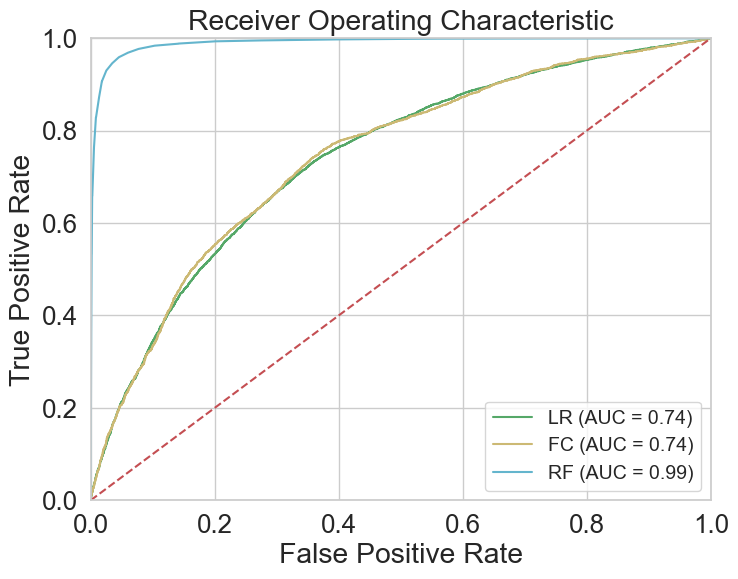

In [181]:
# plot ROC curve for Naive Bays

fpr1, tpr1, threshold1 = metrics.roc_curve(y, probs1)
fpr2, tpr2, threshold2 = metrics.roc_curve(y, probs2)
fpr3, tpr3, threshold3 = metrics.roc_curve(y, probs3)

plt.figure(figsize=(8,6))
plt.plot(fpr1, tpr1, 'g', label = 'LR (AUC = %0.2f)' % auc1)
plt.plot(fpr2, tpr2, 'y', label = 'FC (AUC = %0.2f)' % auc2)
plt.plot(fpr3, tpr3, 'c', label = 'RF (AUC = %0.2f)' % auc3)

plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right',prop={"size":14})
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Predict 2020 songs

In [293]:
# Feature selection
poly = PolynomialFeatures(degree = 2,interaction_only = False)
songfeatures2020 = poly.fit_transform(song2020)
y_rfc = rfc.predict(songfeatures2020)

In [294]:
pred2020 = pd.DataFrame({'name':name2020,'pred':y_rfc})
df2020 = song[song.year==2020][['artists','name','hitsong']]

In [295]:
top = pred2020[pred2020.pred==1]
top = pd.merge(top, df2020, how='left',on = 'name')
top = top.drop_duplicates().reset_index().drop(['index'],axis=1)
top = top.reindex(columns=['name','artists','hitsong','pred'])

In [299]:
top.to_excel("predicted 2020 songs.xlsx")

In [297]:
top.head(50)

,name,artists,hitsong,pred
0,happy does,kenny chesney,1,1
1,sad forever,lauv,0,1
2,como llora,juanfran,0,1
3,2020 riots how many times,trey songz,0,1
4,midnight love,girl in red,0,1
5,if you’re too shy let me know,the 1975,0,1
6,i miss you i’m sorry,gracie abrams,0,1
7,no judgement,niall horan,0,1
8,wetty,fivio foreign,0,1
9,revenge,joyner lucas,0,1


In [298]:
# top songs list in the top 100 billboard
hitsong = top[top.hitsong==1]
hitsong

,name,artists,hitsong,pred
0,happy does,kenny chesney,1,1
22,in too deep,eminem,1,1
23,i remember,rod wave,1,1
26,changes,lauv,1,1
27,changes,justin bieber,1,1
...,...,...,...,...
468,eenie meenie,sean kingston,1,1
469,get up,t-pain,1,1
470,you,luh kel,1,1
485,amazing grace,dababy,1,1
